# ЧАСТЬ ПЕРВАЯ, ВЫБОР МОДЕЛИ ДЛЯ ЭМБЕДДИНГОВ

## ИМПОРТ НЕОБХОДМЫХ БИБЛИОТЕК

In [1]:
import os
import random
from pathlib import Path
import warnings
from tqdm import tqdm

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier




import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

from sentence_transformers import SentenceTransformer
from transformers import (
    AutoTokenizer,
    AutoModel,
    TrainingArguments,
    Trainer,
)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from peft import LoraConfig, get_peft_model

import shap
from collections import Counter

warnings.filterwarnings("ignore")
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)


2025-07-16 13:41:20.798398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752673281.025450      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752673281.088651      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Подгрузка и анализ данных

In [2]:
analis = pd.read_csv('/kaggle/input/cheating-tuesdays/analysed_games.csv')
analis

,tournament_type,tournament_date,tournament_id,game_id,tournament_date_iso,moves,username_white,username_black,chessTitle_white,chessTitle_black,...,isEnabled_white,isEnabled_black,White,Black,Result,ECO,WhiteElo,BlackElo,Termination,is_analysed
0,early-titled-tuesday-blitz,december-12-2023,4427730,96136453865,2023-12-12,113,leschebaza,brm72,FM,NM,...,True,True,leschebaza,brm72,1/2-1/2,A35,2344,2512,Game drawn by insufficient material,True
1,early-titled-tuesday-blitz,june-13-2023,4073113,80409237427,2023-06-13,107,Camilla_Lee,TrahtarBelarus,NM,FM,...,True,True,Camilla_Lee,TrahtarBelarus,1-0,B56,2580,2795,Camilla_Lee won on time,True
2,early-titled-tuesday-blitz,may-16-2023,4020317,77988214797,2023-05-16,52,Elbek_Jumanov,Witik,FM,FM,...,True,True,Elbek_Jumanov,Witik,0-1,D30,2451,2780,Witik won on time,True
3,early-titled-tuesday-blitz,april-04-2023,3947951,74360656481,2023-04-04,78,broskolis,AlexPapasimakopoulos,FM,FM,...,False,True,broskolis,AlexPapasimakopoulos,0-1,C02,2438,2731,AlexPapasimakopoulos won by resignation,True
4,early-titled-tuesday-blitz,december-19-2023,4450894,96744149239,2023-12-19,111,tantaan,UnTucopalaTimba,WFM,WCM,...,True,True,tantaan,UnTucopalaTimba,1/2-1/2,E27,2458,2103,Game drawn by repetition,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161198,early-titled-tuesday-blitz,june-20-2023,4088063,81014435315,2023-06-20,71,Virgo15,SaiHanThiha,GM,FM,...,True,True,Virgo15,SaiHanThiha,1-0,A45,2658,2441,Virgo15 won by resignation,True
161199,early-titled-tuesday-blitz,june-27-2023,4111410,81621867981,2023-06-27,32,Chesstar,Grossboss19,CM,CM,...,True,True,Chesstar,Grossboss19,0-1,B45,2093,2399,Grossboss19 won by resignation,True
161200,late-titled-tuesday-blitz,september-26-2023,4293686,89505007193,2023-09-26,110,glebus008,miraitrunks,FM,NM,...,True,True,glebus008,miraitrunks,0-1,B32,2257,2167,miraitrunks won by resignation,True
161201,late-titled-tuesday-blitz,september-26-2023,4293686,89502674015,2023-09-26,137,Vadim_Biliy,jjbolanos,IM,CM,...,True,True,Vadim_Biliy,jjbolanos,1/2-1/2,D30,2306,2107,Game drawn by insufficient material,True


In [3]:
endgame_start_move = pd.read_csv('/kaggle/input/cheating-tuesdays/endgame_start_move.csv')
endgame_start_move

,game_id,plycount
0,71943899267,49.0
1,71943899277,55.0
2,71943899281,NaN
3,71943899285,55.0
4,71943899287,87.0
...,...,...
161198,96769204261,42.0
161199,96769204263,51.0
161200,96769204271,56.0
161201,96769204279,NaN


In [4]:
moves = pd.read_csv('/kaggle/input/cheating-tuesdays/moves.csv')
moves

,Best Move,Best Move Eval,Real Move,Ranking Real Move,Real Move Eval,plycount,player,difference,move_timestamp,move_time,...,use,is_top1,is_top3,is_top5,move_timestamp_bin,is_endgame,game_length,pv_rank_top3,pv_rank_top2,pv_rank_top1
0,e2e4,0.38,e2e4,1,0.38,1,white,-0.00,177.3,3.7,...,False,True,True,True,0.1,False,37,1,1,1
1,e7e5,0.23,e7e5,1,0.23,2,black,0.00,176.7,4.3,...,True,True,True,True,0.1,False,37,1,1,1
2,g1f3,0.23,g1f3,1,0.23,3,white,-0.00,177.3,1.0,...,False,True,True,True,0.1,False,37,2,2,2
3,b8c6,0.28,b8c6,1,0.28,4,black,0.00,176.7,1.0,...,True,True,True,True,0.1,False,37,2,2,2
4,f1b5,0.28,f1c4,3,0.17,5,white,0.11,172.7,5.6,...,False,False,True,True,0.2,False,37,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14114898,c1d2,99.00,c1d2,1,99.00,73,white,0.00,61.1,1.2,...,True,True,True,True,2.0,True,39,20,5,3
14114899,h1h2,99.00,h1h2,1,99.00,74,black,0.00,3.7,1.0,...,False,True,True,True,3.0,True,38,4,4,4
14114900,d2e3,99.00,d2c3,2,99.00,75,white,0.00,61.6,0.5,...,True,False,True,True,2.0,True,39,21,6,0
14114901,h2c2,99.00,h2c2,1,99.00,76,black,0.00,3.2,1.5,...,False,True,True,True,3.0,True,38,5,5,5


In [5]:
blocked_most_summary = pd.read_csv('/kaggle/input/cheating-tuesdays/users_who_are_blocked_most_summary.csv')
blocked_most_summary

,username,players_played_count,blockedby_count,was_blocked_to_played_player_ratio
0,stollenmonster,490,22,0.044898
1,Orest_Vovk,643,18,0.027994
2,vi_pranav,470,17,0.036170
3,Witik,665,16,0.024060
4,Rud_Makarian,536,15,0.027985
...,...,...,...,...
1184,TitarovVasiliYouTube,9,1,0.111111
1185,PlymouthArgyle,8,1,0.125000
1186,ProphetoftheLord,5,1,0.200000
1187,chessking0310,5,1,0.200000


In [6]:
blocked_most =pd.read_csv('/kaggle/input/cheating-tuesdays/users_who_are_blocked_most.csv')
blocked_most

,username,blockedby,blockedby_count
0,03revilo,Tolyanius,1
1,1800_strength,TigrVShlyape,1
2,2Killer2,Fernando-Freire,1
3,2Tilted,SirParistonHill,1
4,2k28Lakers,Schattman,1
...,...,...,...
2401,stollenmonster,alexrustemov,22
2402,stollenmonster,baki83,22
2403,stollenmonster,djano,22
2404,stollenmonster,mbojan,22


In [7]:
df = pd.read_csv('/kaggle/input/cheating-tuesdays/users_who_block_most_summary.csv')
df

,blockedby,players_played_count,blocks_count,blocked_to_played_player_ratio
0,TigrVShlyape,751,274,0.364847
1,Jospem,626,106,0.169329
2,Guzman70,234,88,0.376068
3,SirParistonHill,303,86,0.283828
4,Lennis93,447,83,0.185682
...,...,...,...,...
482,isaks,8,1,0.125000
483,slavenok,8,1,0.125000
484,FEKKET-ESZTER,6,1,0.166667
485,StegariuVlad,2,1,0.500000


In [8]:
df2 = pd.read_csv('/kaggle/input/cheating-tuesdays/users_who_block_most.csv')
df2

,blockedby,username,blockedby_count,blocks_count
0,827883,Petrovic_Aleksa,3,1
1,AVolodin,wqws,6,1
2,AbasovN,lolo9292,1,1
3,Abund,guillembaches,13,1
4,AdrianaNikolova,glebus008,2,1
...,...,...,...,...
2401,TigrVShlyape,wqws,6,274
2402,TigrVShlyape,xberli,1,274
2403,TigrVShlyape,yosephtaher,1,274
2404,TigrVShlyape,zeitnot2006,1,274


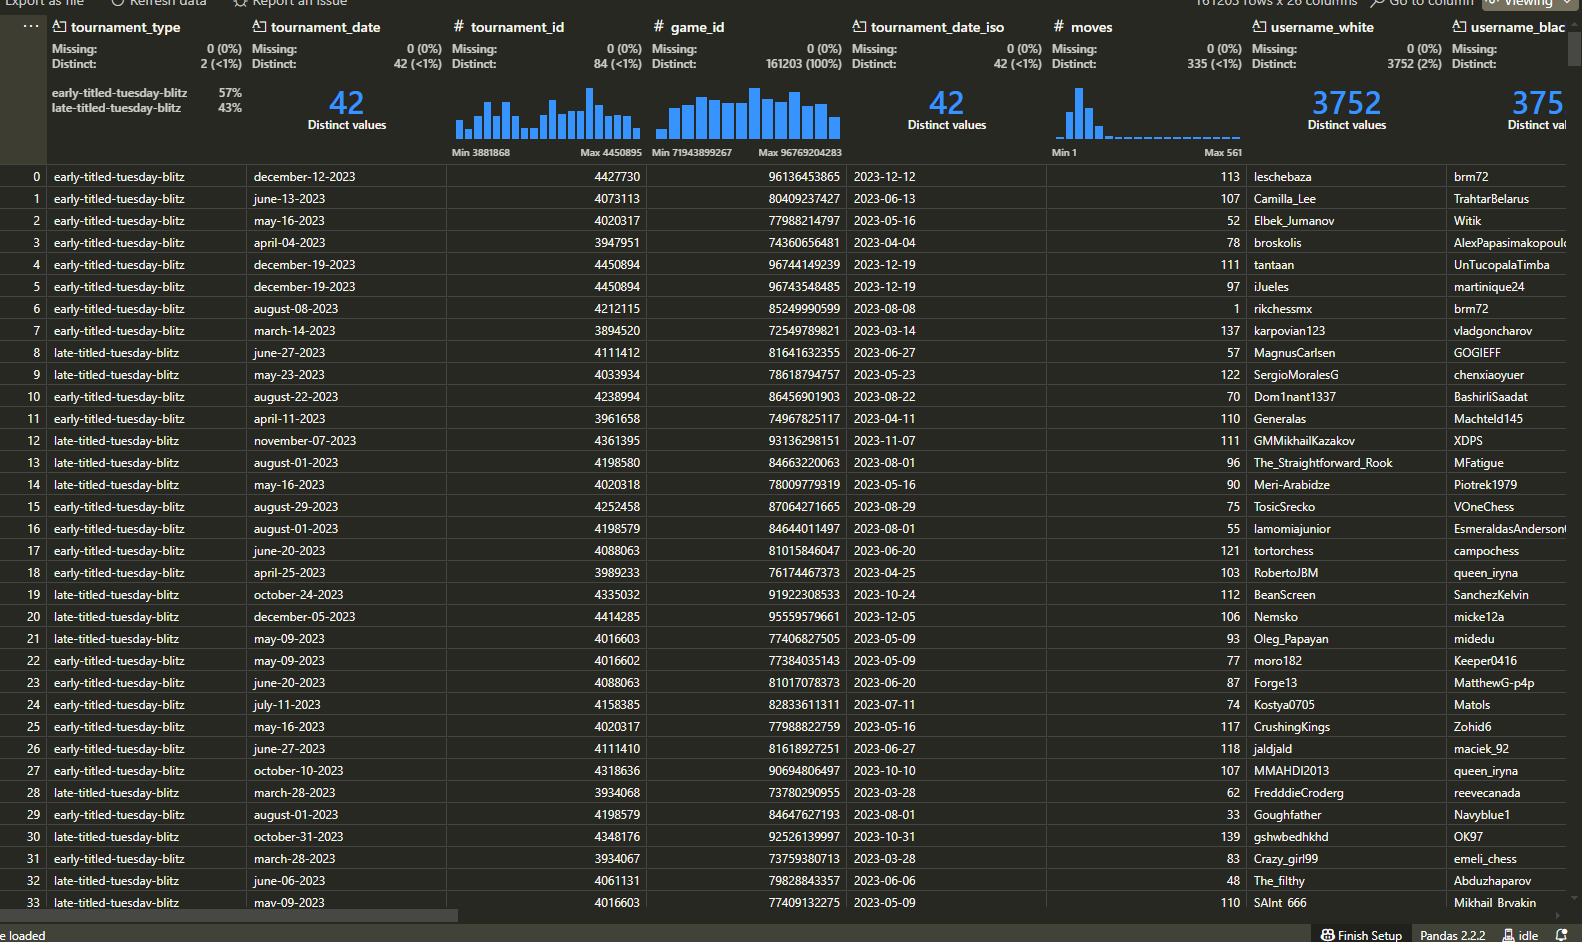

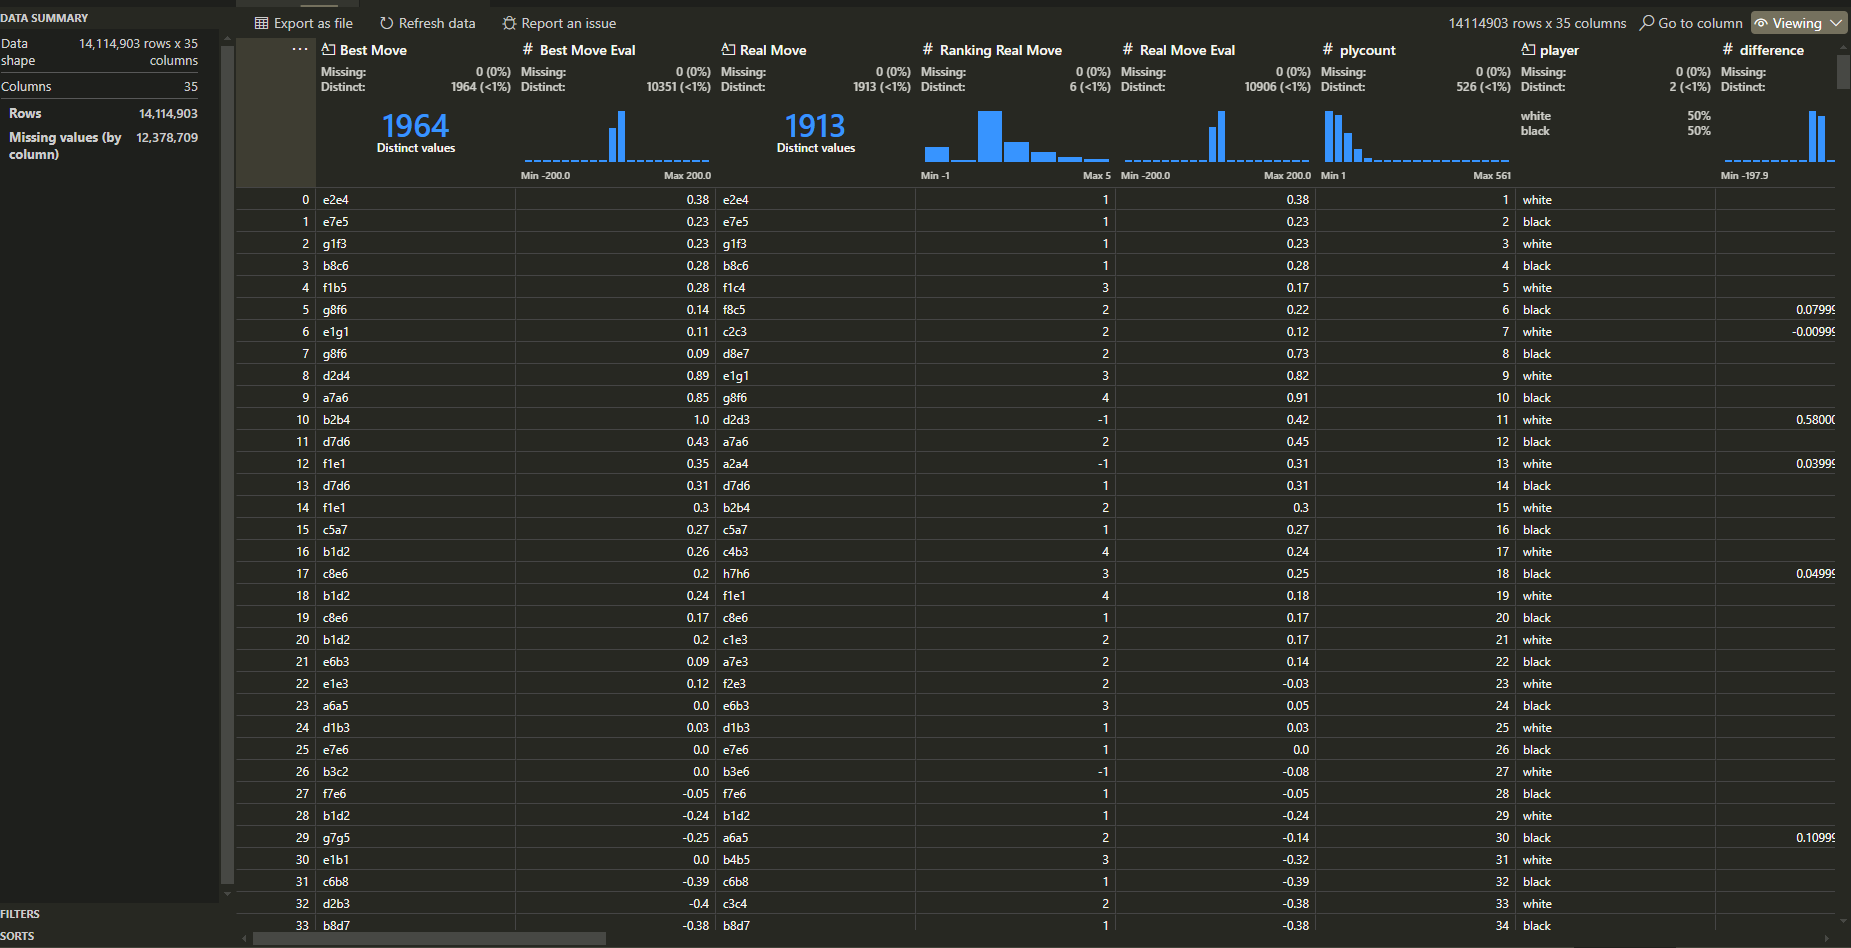

Итог: возьмем некоторые числовые признаки, такие как разница в рейтинге, среднее статистика идеальных ходов за партию и точность ходов, также проэксперементируем с векторайзерами, чтобы понять как лучше создавать эмбеддинги

## Подготовка данных и добавление новых признаков

In [9]:
# подгрузка нужных датафреймов
analis = pd.read_csv('/kaggle/input/cheating-tuesdays/analysed_games.csv')
moves = pd.read_csv('/kaggle/input/cheating-tuesdays/moves.csv')

In [10]:
analis.columns

Index(['tournament_type', 'tournament_date', 'tournament_id', 'game_id',
       'tournament_date_iso', 'moves', 'username_white', 'username_black',
       'chessTitle_white', 'chessTitle_black', 'countryName_white',
       'countryName_black', 'isBlocked_white', 'isBlocked_black',
       'isEnabled_white', 'isEnabled_black', 'White', 'Black', 'Result', 'ECO',
       'WhiteElo', 'BlackElo', 'Termination', 'is_analysed'],
      dtype='object')

In [11]:
moves.columns

Index(['Best Move', 'Best Move Eval', 'Real Move', 'Ranking Real Move',
       'Real Move Eval', 'plycount', 'player', 'difference', 'move_timestamp',
       'move_time', 'winning_chances', 'winning_chances_before',
       'move_accuracy', 'winning_chances_delta', 'judgement', 'game_id',
       'username', 'move', 'game_result', 'did_flag', 'was_flagged', 'ELO',
       'is_error', 'is_blunder', 'skip', 'use', 'is_top1', 'is_top3',
       'is_top5', 'move_timestamp_bin', 'is_endgame', 'game_length',
       'pv_rank_top3', 'pv_rank_top2', 'pv_rank_top1'],
      dtype='object')

выделяем целевую переменную

In [12]:
analis["is_flagged"] = ((analis["isBlocked_white"] == True) | (analis["isBlocked_black"] == True)).astype(int)

In [13]:
# очень сильный дисбаланс классов
Counter(analis['is_flagged'])

Counter({0: 159181, 1: 2022})

Добавим числовые признаки и преобразование ходов партей для подачи в трансформеры

In [14]:
analis["elo_diff"] = analis["WhiteElo"] - analis["BlackElo"]

analis_f = analis[["game_id", "elo_diff", "is_flagged"]].copy()

ftd = moves[["game_id", "Real Move", "Best Move Eval", "move_accuracy"]].copy()
ftd = ftd[ftd["Real Move"].notna()]
ftd["Real Move"] = ftd["Real Move"].str.lower()

agg = ftd.groupby("game_id").agg({
    "Real Move": lambda x: list(x),
    "Best Move Eval": "mean",
    "move_accuracy": "mean"
}).reset_index()

agg.columns = ["game_id", "move_list", "mean_best_eval", "mean_move_accuracy"]

fdf = analis_f.merge(agg, on="game_id", how="inner")

fdf.head(3)

,game_id,elo_diff,is_flagged,move_list,mean_best_eval,mean_move_accuracy
0,96136453865,-168,0,"[g1f3, c7c5, c2c4, b8c6, e2e3, g8f6, b1c3, g7g...",0.009292,96.173776
1,80409237427,-215,0,"[e2e4, c7c5, g1f3, d7d6, d2d4, c5d4, f3d4, g8f...",0.879813,91.833048
2,77988214797,-329,0,"[c2c4, e7e6, g1f3, d7d5, d2d4, g8f6, g2g3, f8b...",-0.455000,92.570766


Было принято решение добавить эмбеддинги ходов партиий с помощью предобученного трансформера С HUGGING FACE nsarrazin/chessformer

In [15]:
model_name = "nsarrazin/chessformer"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/928M [00:00<?, ?B/s]

Some weights of GPT2Model were not initialized from the model checkpoint at nsarrazin/chessformer and are newly initialized: ['wte.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2Model(
  (wte): Embedding(4613, 1024)
  (wpe): Embedding(512, 1024)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-17): 18 x GPT2Block(
      (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=3072, nx=1024)
        (c_proj): Conv1D(nf=1024, nx=1024)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=4096, nx=1024)
        (c_proj): Conv1D(nf=1024, nx=4096)
        (act): SiLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [16]:
# Приводим данные в нужный формат для подачи в трансформер
fdf["moves_str"] = fdf["move_list"].apply(lambda moves: " ".join(moves))

In [17]:
fdf

,game_id,elo_diff,is_flagged,move_list,mean_best_eval,mean_move_accuracy,moves_str
0,96136453865,-168,0,"[g1f3, c7c5, c2c4, b8c6, e2e3, g8f6, b1c3, g7g...",0.009292,96.173776,g1f3 c7c5 c2c4 b8c6 e2e3 g8f6 b1c3 g7g6 d2d4 c...
1,80409237427,-215,0,"[e2e4, c7c5, g1f3, d7d6, d2d4, c5d4, f3d4, g8f...",0.879813,91.833048,e2e4 c7c5 g1f3 d7d6 d2d4 c5d4 f3d4 g8f6 b1c3 b...
2,77988214797,-329,0,"[c2c4, e7e6, g1f3, d7d5, d2d4, g8f6, g2g3, f8b...",-0.455000,92.570766,c2c4 e7e6 g1f3 d7d5 d2d4 g8f6 g2g3 f8b4 c1d2 b...
3,74360656481,-293,0,"[e2e4, e7e6, d2d4, d7d5, e4e5, a7a6, c2c3, c8d...",-3.038077,90.159716,e2e4 e7e6 d2d4 d7d5 e4e5 a7a6 c2c3 c8d7 g1f3 d...
4,96744149239,355,0,"[d2d4, g8f6, c2c4, e7e6, b1c3, f8b4, f2f3, e8g...",-0.433604,91.119214,d2d4 g8f6 c2c4 e7e6 b1c3 f8b4 f2f3 e8g8 a2a3 b...
...,...,...,...,...,...,...,...
161198,81014435315,217,0,"[d2d4, g8f6, c1f4, e7e6, e2e3, c7c5, b1d2, c5d...",4.812535,92.253344,d2d4 g8f6 c1f4 e7e6 e2e3 c7c5 b1d2 c5d4 e3d4 b...
161199,81621867981,-306,0,"[e2e4, c7c5, g1f3, b8c6, d2d4, c5d4, f3d4, e7e...",-0.973437,94.680115,e2e4 c7c5 g1f3 b8c6 d2d4 c5d4 f3d4 e7e6 b1c3 g...
161200,89505007193,90,0,"[e2e4, c7c5, g1f3, b8c6, d2d4, c5d4, f3d4, e7e...",-20.351091,92.041607,e2e4 c7c5 g1f3 b8c6 d2d4 c5d4 f3d4 e7e5 d4b5 a...
161201,89502674015,199,0,"[d2d4, g8f6, g1f3, e7e6, e2e3, d7d5, c2c4, f8e...",-5.920000,94.339092,d2d4 g8f6 g1f3 e7e6 e2e3 d7d5 c2c4 f8e7 f1e2 e...


Перед тем как векторизировать и обучать перобразуем датафрейм, так чтобы не было большого дисбаланса классов, сократив его до 6000 строк, так как недостаточно вычислительных мощностей, чтобы провекторизировать такое большое количество партий и дальше работать с полученным объемом данных

In [18]:
# сокращение количества данных
block = fdf[fdf["is_flagged"] == 1]
clear = fdf[fdf["is_flagged"] == 0]

block2 = block.sample(n=2000, random_state=42)
clean2 = clear.sample(n=4000, random_state=42)

fdf = pd.concat([block2, clean2]).sample(frac=1, random_state=42).reset_index(drop=True)
fdf.shape

(6000, 7)

In [19]:
# Функция для генерации эмбендингов и их обработки
@torch.no_grad()
def get_embedding(move_str):
    inputs = tokenizer(move_str, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)

    embedding = outputs.last_hidden_state[:, 0, :]
    return embedding.squeeze(0).numpy()

In [20]:
# добавление векторизированных партий в датафрейм
subset = fdf.copy()
subset["moves_str"] = subset["move_list"].apply(lambda moves: " ".join(moves))

embeddings = []
for moves in tqdm(subset["moves_str"]):
    try:
        emb = get_embedding(moves)
    except Exception as e:
        emb = torch.zeros(model.config.hidden_size).numpy()
    embeddings.append(emb)


embedding_size = embeddings[0].shape[0]


embed_df = pd.DataFrame(embeddings, columns=[f"chessformer_{i}" for i in range(embedding_size)])
sub_df_em = pd.concat([subset.reset_index(drop=True), embed_df], axis=1)


sub_df_em.head(2)

100%|██████████| 6000/6000 [31:06<00:00,  3.21it/s]


,game_id,elo_diff,is_flagged,move_list,mean_best_eval,mean_move_accuracy,moves_str,chessformer_0,chessformer_1,chessformer_2,...,chessformer_1014,chessformer_1015,chessformer_1016,chessformer_1017,chessformer_1018,chessformer_1019,chessformer_1020,chessformer_1021,chessformer_1022,chessformer_1023
0,95532717803,363,1,"[g1f3, d7d5, g2g3, g8f6, f1g2, c7c6, e1g1, c8f...",0.957975,92.981657,g1f3 d7d5 g2g3 g8f6 f1g2 c7c6 e1g1 c8f5 d2d3 h...,0.116728,-0.195796,0.008380,...,0.139772,-0.166790,0.758208,0.101578,-0.185533,-0.076555,0.333131,-0.284470,-0.218849,-0.246194
1,80432532193,239,0,"[d2d4, d7d6, g1f3, g7g6, c1g5, f8g7, b1d2, b8d...",2.235455,92.186043,d2d4 d7d6 g1f3 g7g6 c1g5 f8g7 b1d2 b8d7 e2e3 h...,0.106060,-0.170173,-0.012343,...,0.131372,-0.159452,0.692004,0.139699,-0.191500,-0.084390,0.358880,-0.260805,-0.172608,-0.240525


In [21]:
sub_df_em.to_csv('ml_data.csv',index = False)

## ML модели и сравнение метрик с разными эмбеддингами

In [22]:
# фичи для подачи в модель
features = ['elo_diff', 'mean_best_eval', 'mean_move_accuracy'] + \
[col for col in sub_df_em.columns if col.startswith("chessformer_")]

In [23]:
# выделяем признаки для обучения и целевую переменную
X = sub_df_em[features]
y = sub_df_em['is_flagged']

In [24]:
# разбиение данных на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Обучим catboost и сравним с другими бустингами

In [25]:
model = CatBoostClassifier(
    iterations=1000,
    depth=8,
    eval_metric='AUC',
    verbose=100,
    random_seed=42,
    od_wait = 100
)
model.fit(X_train, y_train, eval_set=(X_test, y_test),use_best_model=True,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.04517
0:	test: 0.5154646	best: 0.5154646 (0)	total: 78.9ms	remaining: 1m 18s
100:	test: 0.5914514	best: 0.5917792 (65)	total: 5.34s	remaining: 47.6s
200:	test: 0.5980681	best: 0.5982097 (199)	total: 11.1s	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5982097222
bestIteration = 199

Shrink model to first 200 iterations.


In [26]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.67      0.98      0.80      1200
           1       0.43      0.03      0.05       600

    accuracy                           0.66      1800
   macro avg       0.55      0.50      0.42      1800
weighted avg       0.59      0.66      0.55      1800

ROC AUC: 0.5982097222222222


### lightgbm

In [27]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)


params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'random_state': 42
}

lgb_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=1000,
)



In [28]:
y_pred = (lgb_model.predict(X_test) > 0.5).astype(int)
y_proba = lgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.69      0.81      0.74      1200
           1       0.40      0.26      0.32       600

    accuracy                           0.63      1800
   macro avg       0.54      0.53      0.53      1800
weighted avg       0.59      0.63      0.60      1800

ROC AUC: 0.554136111111111


### Теперь обучим starter ансамбль

In [29]:


catboost_model = CatBoostClassifier(
    iterations=300, learning_rate=0.05, depth=6,
    verbose=0, random_seed=42
)

lgbm_model = LGBMClassifier(
    n_estimators=300, learning_rate=0.05,
    num_leaves=31, random_state=42
)

xgb_model = XGBClassifier(
    n_estimators=300, learning_rate=0.05,
    max_depth=6, use_label_encoder=False,
    eval_metric='logloss', random_state=42
)

adaboost_model = AdaBoostClassifier(
    n_estimators=300, learning_rate=0.05, random_state=42
)

# 2. Ансамбль
voting_clf = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('lightgbm', lgbm_model),
        ('xgboost', xgb_model),
        ('adaboost', adaboost_model)
    ],
    voting='soft'  # используем вероятности
)


voting_clf.fit(X_train, y_train)



VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7ea0d8b99490>),
                             ('lightgbm',
                              LGBMClassifier(learning_rate=0.05,
                                             n_estimators=300,
                                             random_state=42)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=...
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('adaboost',
                              AdaBoostClassifier(learning_rate=0.05,
                                                 n_estimators=300,
                                                 random_state=42))],
                 voting='soft')

In [30]:
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]


print(classification_report(y_test, y_pred))


print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.69      0.93      0.79      1200
           1       0.53      0.15      0.24       600

    accuracy                           0.67      1800
   macro avg       0.61      0.54      0.51      1800
weighted avg       0.63      0.67      0.61      1800

ROC AUC: 0.5929041666666667


Итог: написали бейзлайн, далее стоит определиться с трансформером

### Пробуем другие векторайзеры

возьмем distilbert

In [31]:
model_name = "distilbert-base-uncased"
tokenizer_distil = AutoTokenizer.from_pretrained(model_name)
model_distil = AutoModel.from_pretrained(model_name)
model_distil.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [32]:
@torch.no_grad()
def get_distilbert_embedding(text):
    inputs = tokenizer_distil(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model_distil(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

In [33]:
subset["moves_str"] = subset["move_list"].apply(lambda moves: " ".join(moves))

distilbert_embeddings = []
for moves in tqdm(subset["moves_str"]):
    try:
        emb = get_distilbert_embedding(moves)
    except Exception as e:
        emb = np.zeros(model_distil.config.hidden_size)
    distilbert_embeddings.append(emb)

distil_size = distilbert_embeddings[0].shape[0]
distil_df = pd.DataFrame(distilbert_embeddings, columns=[f"distilbert_{i}" for i in range(distil_size)])
subset_embedded_bert = pd.concat([subset.reset_index(drop=True), distil_df], axis=1)

100%|██████████| 6000/6000 [16:08<00:00,  6.20it/s]


Так же возьмем классический мешок слов

In [35]:
from gensim.models import Word2Vec

corpus = subset["move_list"].tolist()
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4, seed=42)

w2v_size = w2v_model.vector_size

In [36]:
def get_w2v_embedding(moves):
    vectors = [w2v_model.wv[move] for move in moves if move in w2v_model.wv]
    if not vectors:
        return np.zeros(w2v_size)
    return np.mean(vectors, axis=0)

In [37]:
w2v_embeddings = []

for moves in tqdm(subset["move_list"]):
    try:
        emb = get_w2v_embedding(moves)
    except Exception as e:
        emb = np.zeros(w2v_size)
    w2v_embeddings.append(emb)

w2v_embed_df = pd.DataFrame(w2v_embeddings, columns=[f"w2v_{i}" for i in range(w2v_size)])

subset_embedded_w2w = pd.concat([subset.reset_index(drop=True), w2v_embed_df], axis=1)

100%|██████████| 6000/6000 [00:00<00:00, 6763.37it/s]


### Сравнение точности на разных эмбедингах

distilbert

In [38]:
features_bert = ['elo_diff', 'mean_best_eval', 'mean_move_accuracy'] + \
[col for col in subset_embedded_bert.columns if col.startswith("distilbert_")]

In [39]:
X_bert = subset_embedded_bert[features_bert]
y_bert = subset_embedded_bert['is_flagged']

In [40]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_bert, y_bert, test_size=0.3, stratify=y, random_state=42)

In [41]:
model = CatBoostClassifier(
    iterations=1000,
    depth=8,
    eval_metric='AUC',
    verbose=100,
    random_seed=42,
    od_wait = 100
)
model.fit(X_train2, y_train2, eval_set=(X_test2, y_test2),use_best_model=True,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.04517
0:	test: 0.4936396	best: 0.4936396 (0)	total: 512ms	remaining: 8m 31s
100:	test: 0.5606708	best: 0.5681347 (56)	total: 31.1s	remaining: 4m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5681347222
bestIteration = 56

Shrink model to first 57 iterations.


In [42]:
y_pred2 = model.predict(X_test2)
y_proba2 = model.predict_proba(X_test2)[:, 1]

print("📋 Classification Report:")
print(classification_report(y_test2, y_pred2))

print("ROC AUC:", roc_auc_score(y_test2, y_proba2))

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1200
           1       0.00      0.00      0.00       600

    accuracy                           0.67      1800
   macro avg       0.33      0.50      0.40      1800
weighted avg       0.44      0.67      0.53      1800

ROC AUC: 0.5681347222222222


w2v

In [43]:
features_w2w = ['elo_diff', 'mean_best_eval', 'mean_move_accuracy'] + \
[col for col in subset_embedded_w2w.columns if col.startswith("w2v_")]

In [44]:
X_w2v = subset_embedded_w2w[features_w2w]
y_w2v = subset_embedded_w2w['is_flagged']

In [45]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_w2v, y_w2v, test_size=0.3, stratify=y, random_state=42)

In [46]:
model = CatBoostClassifier(
    iterations=1000,
    depth=8,
    eval_metric='AUC',
    verbose=100,
    random_seed=42,
    od_wait = 100
)
model.fit(X_train3, y_train3, eval_set=(X_test3, y_test3),use_best_model=True,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.04517
0:	test: 0.5153403	best: 0.5153403 (0)	total: 84.7ms	remaining: 1m 24s
100:	test: 0.5516653	best: 0.5587750 (39)	total: 4.39s	remaining: 39.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.558775
bestIteration = 39

Shrink model to first 40 iterations.


In [47]:
y_pred3 = model.predict(X_test3)
y_proba3 = model.predict_proba(X_test3)[:, 1]

print(classification_report(y_test3, y_pred3))

print("ROC AUC:", roc_auc_score(y_test3, y_proba3))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80      1200
           1       0.00      0.00      0.00       600

    accuracy                           0.67      1800
   macro avg       0.33      0.50      0.40      1800
weighted avg       0.44      0.67      0.53      1800

ROC AUC: 0.558775


построим график насколько различаются метрики

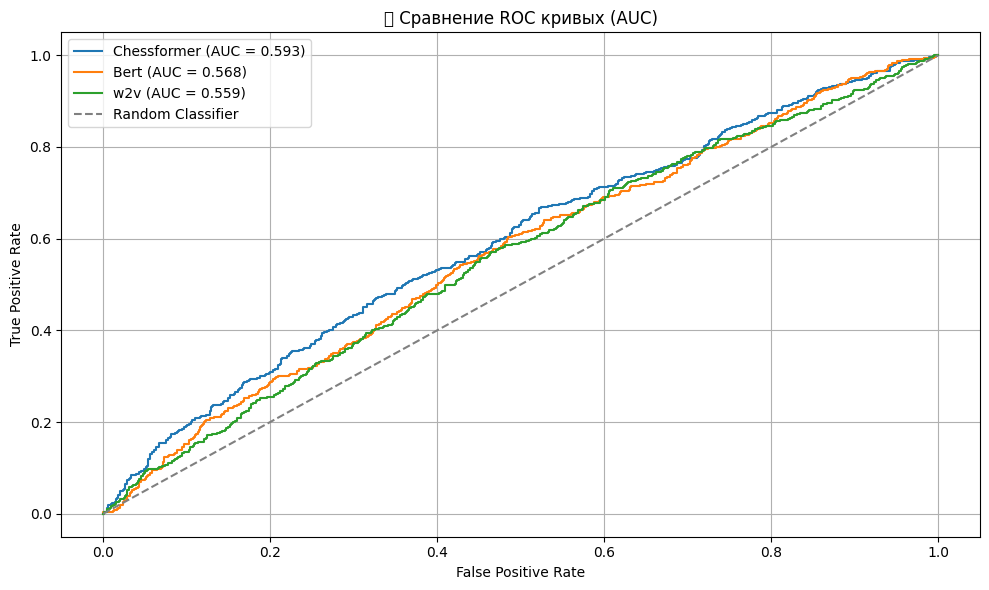

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

models = {
    "Chessformer": (y_test, y_proba),
    "Bert": (y_test2, y_proba2),
    "w2v": (y_test3, y_proba3)
}

plt.figure(figsize=(10, 6))

for model_name, (y_true, y_prob) in models.items():
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")

plt.title("📊 Сравнение ROC кривых (AUC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Вывод: после сравнения метрик ясно, что лучше всего использовать специализорованный трансформер для создания эмбедингов

## Работа с нейросетями, вторая часть улучшаем качество

### Обучаем Мультимодальную сеть: ChessFormer + двухслойный MLP.

In [ ]:
# объявляем параметры
os.environ["TRANSFORMERS_NO_TF"] = "1"; os.environ["TRANSFORMERS_NO_FLAX"] = "1"

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Analis = '/kaggle/input/cheating-tuesdays/analysed_games.csv'
Moves    = '/kaggle/input/cheating-tuesdays/moves.csv'
Model   = "nsarrazin/chessformer"
Mlen = 256; batch = 16; block, total = 2000, 6000

In [ ]:
#  подгрузим и сократим датафрейм
analysed = pd.read_csv(Analis)
moves   = pd.read_csv(Moves)
flag_col = "did_flag" if "did_flag" in moves.columns else ("was_flagged" if "was_flagged" in moves.columns else None)


moves = moves[moves.game_id.isin(analysed.game_id)]
flag_ids = moves.loc[moves[flag_col]==1, "game_id"].unique(); np.random.shuffle(flag_ids)
clean_ids= moves.loc[moves[flag_col]==0, "game_id"].unique(); np.random.shuffle(clean_ids)
sel_ids  = set(flag_ids[:block]) | set(clean_ids[:total-block])
sel_moves= moves[moves.game_id.isin(sel_ids)]


TOKENIZER = AutoTokenizer.from_pretrained(Model, use_fast=True)

In [ ]:
# добавлям числовые признаки 
def features(s):
    cur=best=0
    for v in s: cur=cur+1 if v else 0; best=max(best,cur)
    return best

seqs, feats, labels = [], [], []
for _, g in sel_moves.groupby("game_id"):
    seqs.append(g.move.astype(str).tolist())
    labels.append(int(g[flag_col].iloc[0]))
    ev = pd.to_numeric(g["Real Move Eval"], errors="coerce")*100
    feats.append({
        "ratio_top1":g.is_top1.mean(),"ratio_top3":g.is_top3.mean(),"ratio_top5":g.is_top5.mean(),
        "streak_top1":features(g.is_top1),
        "cpl_mean":ev.abs().mean(),"cpl_q90":ev.abs().quantile(.9),
        "eval_diff":ev.diff().abs().mean(),
        "blunder_r":g.is_blunder.mean(),"error_r":g.is_error.mean(),
        "acc_mean":g.move_accuracy.mean(),"ply":len(g)})

scaler = StandardScaler().fit(pd.DataFrame(feats).fillna(0))
X_num = scaler.transform(pd.DataFrame(feats).fillna(0))
labels = np.array(labels)

In [ ]:
# разделям данные на обучающую и тестовую выборки
seq_tr, seq_val, num_tr, num_val, y_tr, y_val = train_test_split(
    seqs, X_num, labels, test_size=0.2, stratify=labels, random_state=SEED)

In [ ]:
# кастомный датасет для данных
class DS(torch.utils.data.Dataset):
    def __init__(self, s, n, y):
        self.s, self.n, self.y = s, n, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        enc = TOKENIZER(
            " ".join(self.s[i]),
            truncation=True,
            padding="max_length",
            max_length=Mlen,
            return_tensors="pt",
        )
        d = {k: v.squeeze(0) for k, v in enc.items()}   
        d["numeric"] = torch.tensor(self.n[i], dtype=torch.float32)
        d["label"]   = torch.tensor(self.y[i])
        return d


Архитектура нейросети использует предобученную языковую модель nsarrazin/chessformer с размороженными последними слоями, добавляя к тексту числовые признаки и обрабатывая их через отдельные головы перед объединением и классификацией.

In [ ]:
# нейросеть
class Net(nn.Module):
    def __init__(self, n_num):
        super().__init__()
        self.back = AutoModel.from_pretrained(Model)
        self.back.config.use_cache = False
        for p in self.back.parameters():
            p.requires_grad = False
        for layer in self.back.h[-2:]:
            for p in layer.parameters():
                p.requires_grad = True


        self.attn_vec = nn.Parameter(torch.zeros(self.back.config.n_embd))


        self.num_head = nn.Sequential(
            nn.Linear(n_num, 64), nn.ReLU(), nn.LayerNorm(64), nn.Dropout(0.1))


        self.txt_head = nn.Sequential(
            nn.Linear(self.back.config.n_embd, 384), nn.GELU(), nn.LayerNorm(384), nn.Dropout(0.2),
            nn.Linear(384, 128), nn.GELU())


        self.cls = nn.Sequential(
            nn.Linear(128 + 64, 128), nn.GELU(), nn.Dropout(0.3),
            nn.Linear(128, 2))

        self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1., 2.]).to(DEVICE))

    def forward(self, input_ids=None, attention_mask=None, numeric=None, label=None, **kwargs):
        hs = self.back(input_ids=input_ids, attention_mask=attention_mask, use_cache=False).last_hidden_state

        w = torch.einsum("bld,d->bl", hs, self.attn_vec)
        w = torch.softmax(w.masked_fill(attention_mask==0, -1e9), dim=1).unsqueeze(-1)
        pooled = (hs * w).sum(1)

        txt = self.txt_head(pooled) 
        num = self.num_head(numeric)  
        logits = self.cls(torch.cat([txt, num], 1))
        loss = self.loss_fn(logits, label) if label is not None else None
        return logits, loss

In [ ]:
# обучаем
NUM_EPOCHS = 5
train_loader = DataLoader(DS(seq_tr,num_tr,y_tr), batch_size=batch, shuffle=True)
val_loader   = DataLoader(DS(seq_val,num_val,y_val), batch_size=batch*2)
model = Net(X_num.shape[1]).to(DEVICE)
opt = torch.optim.AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=2e-5)

for epoch in range(NUM_EPOCHS):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", total=len(train_loader))
    model.train()
    for batch in pbar:
        for k in batch: batch[k] = batch[k].to(DEVICE)
        opt.zero_grad(); _, loss = model(**batch); loss.backward(); opt.step()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
print("training finished")

In [ ]:
# смотрим результат
model.eval(); probs,gts=[],[]
with torch.no_grad():
    for b in val_loader:
        for k in b: b[k]=b[k].to(DEVICE)
        logits,_=model(**b); probs.append(torch.softmax(logits,1)[:,1].cpu().numpy()); gts.append(b["label"].cpu().numpy())
probs=np.concatenate(probs); gts=np.concatenate(gts)
print("ROC‑AUC", roc_auc_score(gts,probs).round(4))
print(classification_report(gts,probs>0.5, digits=3))

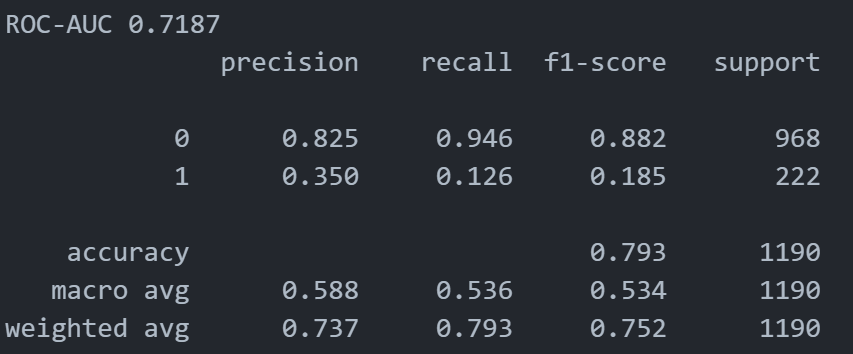

### Итог: Нейросеть значительно увеличила качество,  следовательно для того чтобы поднять качество еще, следует использовать ансамбль dl и ml моделей


Немного меняем структуру нейросети и объединяем в ансамбле с моделью машинного обучения

In [ ]:
# обновленный кастом датасет
class GamesDS(Dataset):
    def __init__(self, seqs, nums, labels):
        self.seqs, self.nums, self.labels = seqs, nums, labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        enc = TOKENIZER(" ".join(self.seqs[idx]), padding="max_length", truncation=True,
                         max_length=Mlen, return_tensors="pt")
        out = {k: v.squeeze(0) for k, v in enc.items()}
        out["numeric"] = torch.tensor(self.nums[idx], dtype=torch.float32)
        out["label"]   = torch.tensor(self.labels[idx])
        return out

Эта чуть улучшенная нейросеть, которая делает то же самое, но с использованием LoRA — более лёгкой техники дообучения без разморозки весов, и при этом сильно упрощает архитектуру, жертвуя глубиной ради скорости и эффективности.

In [ ]:
# архитектура
class LoraNet(nn.Module):
    def __init__(self, n_num):
        super().__init__()
        base = AutoModel.from_pretrained(Model)
        lora_cfg = LoraConfig(task_type=TaskType.SEQ_CLS, r=8, lora_alpha=32,
                              lora_dropout=0.05, target_modules=["c_attn", "c_proj"])
        self.back = get_peft_model(base, lora_cfg)
        self.back.config.use_cache = False
        self.att = nn.Parameter(torch.zeros(self.back.config.n_embd))
        self.num_head = nn.Sequential(nn.Linear(n_num, 64), nn.ReLU())
        self.cls = nn.Linear(self.back.config.n_embd + 64, 2)
        self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1., 2.]).to(DEVICE))
    def forward(self, input_ids=None, attention_mask=None, numeric=None, label=None, **kw):
        h = self.back(input_ids=input_ids, attention_mask=attention_mask, use_cache=False).last_hidden_state
        w = torch.einsum("bld,d->bl", h, self.att)
        w = torch.softmax(w.masked_fill(attention_mask == 0, -1e9), 1).unsqueeze(-1)
        emb = (h * w).sum(1)
        x = torch.cat([emb, self.num_head(numeric)], 1)
        logits = self.cls(x)
        loss = self.loss_fn(logits, label) if label is not None else None
        return logits, loss

In [ ]:

train_dl = DataLoader(GamesDS(seq_tr, num_tr, y_tr), batch_size=16, shuffle=True)
val_dl   = DataLoader(GamesDS(seq_val, num_val, y_val), batch_size=32)


model = LoraNet(X_num.shape[1]).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=2e-5)

train_losses = []

for epoch in range(5):
    epoch_losses = []
    model.train()
    pbar = tqdm(train_dl, desc=f"LoRA epoch {epoch+1}/5")
    
    for batch in pbar:
        for k in batch:
            batch[k] = batch[k].to(DEVICE)
        
        opt.zero_grad()
        _, loss = model(**batch)
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_loss)

print("training finished")

plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("LoRA Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

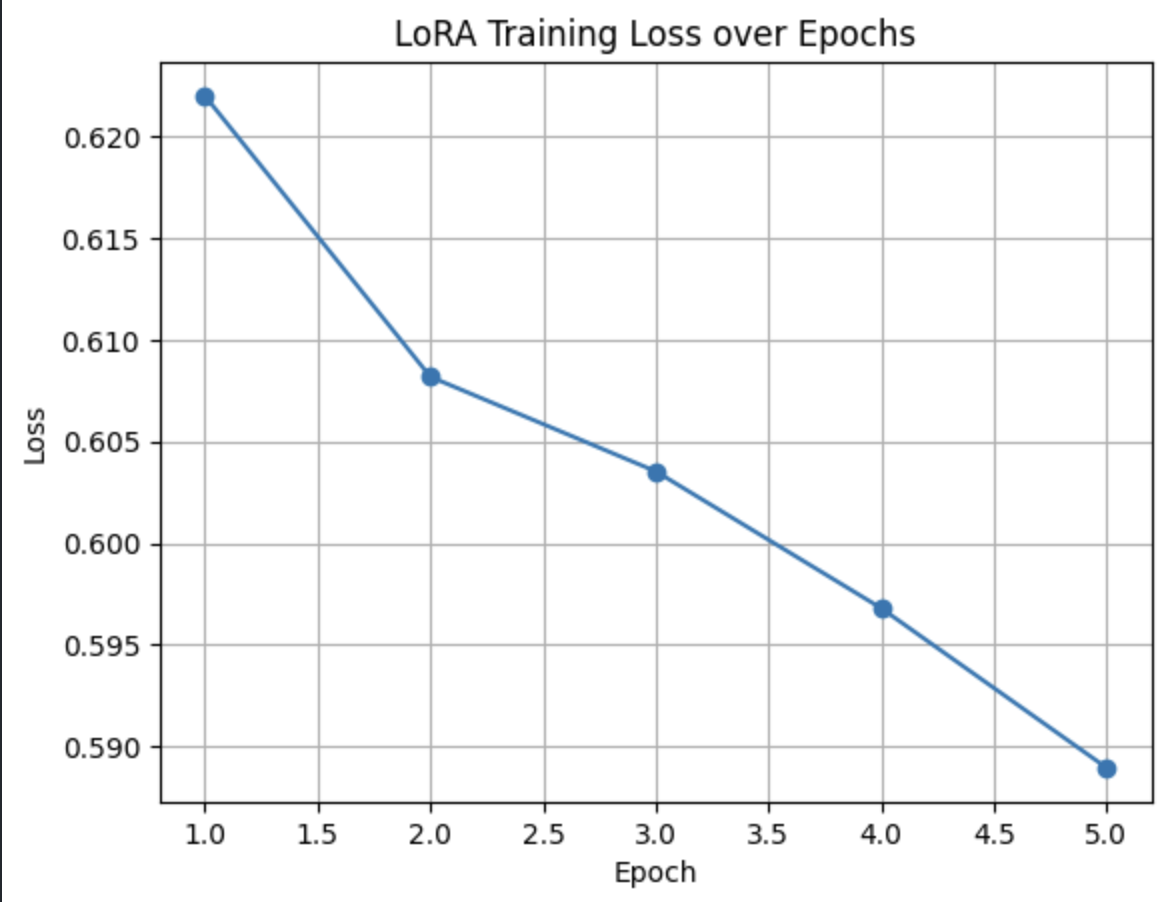

In [ ]:
model.eval(); lora_probs=[]
with torch.no_grad():
    for batch in val_dl:
        for k in batch: batch[k] = batch[k].to(DEVICE)
        logits,_ = model(**batch)
        lora_probs.append(torch.softmax(logits, 1)[:,1].cpu().numpy())
prob_lora = np.concatenate(lora_probs)

In [ ]:
lgb_train = lgb.Dataset(num_tr, label=y_tr)
lgb_val   = lgb.Dataset(num_val, label=y_val, reference=lgb_train)
params = dict(objective="binary", metric="auc", seed=SEED,
              learning_rate=0.05, num_leaves=31)
clf = lgb.train(params, lgb_train, 150, valid_sets=[lgb_val])
prob_lgb = clf.predict(num_val, num_iteration=clf.best_iteration)

In [ ]:
prob_ens = 0.5 * prob_lora + 0.5 * prob_lgb

print(f"ROC‑AUC ENSEMBLE  {roc_auc_score(y_val, prob_ens):.4f}")
print(classification_report(y_val, prob_ens > 0.5, digits=3))

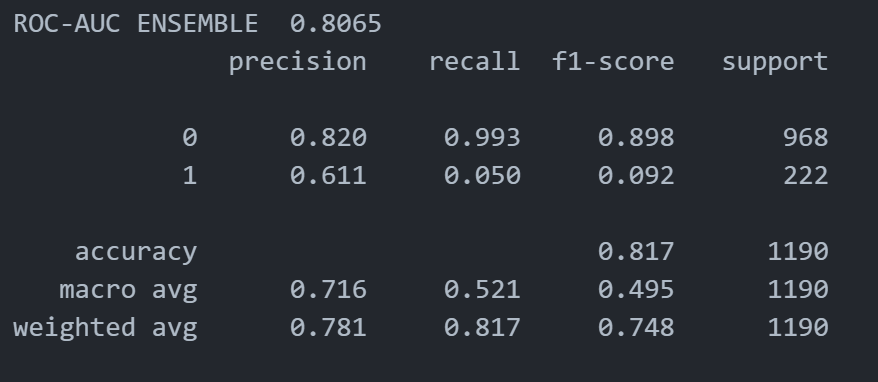

In [ ]:
models = ['DL', 'ML', 'Ensemble']

roc_auc_lora = 0.70
roc_auc_lgb = 0.60
roc_auc_ens = 0.80

roc_aucs = [roc_auc_lora, roc_auc_lgb, roc_auc_ens]
plt.figure(figsize=(6, 4))
plt.bar(models, roc_aucs, color='skyblue')
plt.ylim(0, 1)
plt.title('Сравнение моделей по ROC-AUC')
plt.ylabel('ROC-AUC')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

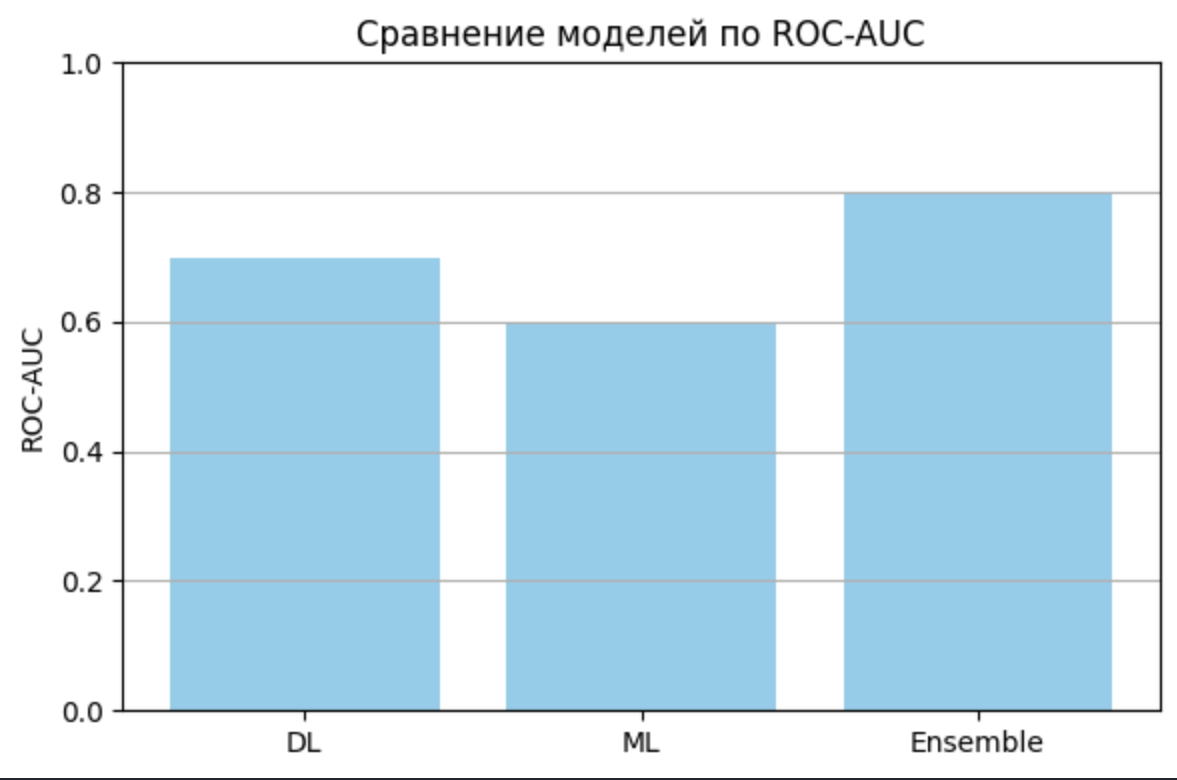

# Вывод: Надо использовать специально предобученные модели и дополнительные признаки, лучшее качество показал ансамбль нейросети и модели машинного обучения. Качество (ROC AUC = 0.8) можно улучшить на более большом объеме данных и с использованием более мощных архитектур